## Group Project: Financial Security Analysis and Portfolio Mgmt.
**By: Ashish Mathew, Bowen Gu**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
%matplotlib inline

### Part I: Portfolio Optimization

1. Collect pricing data for 3 risky assets
    - Calculate mean daily return, variance, standard deviation, skew, kurtosis, covariance, correlation of the risky assets
    - T-bill data calculate average annualized rate, convert. it to daily rate
2. Graph investment oopportunity set (efficient frontier)
3. Find optimal weights that maximize the sharpe ratio of the portfolio
4. Evaluate portfolio on out of sample data

In [165]:
def returnCharacteristics(tickers,start_date,end_date):
    df = yf.download(tickers,start_date,end_date)
    df = df['Close']
    prices = 100 * df.pct_change().dropna()

    tbill = pd.read_csv("./data/TB3MS.csv")
    tbill['observation_date'] = pd.to_datetime(tbill['observation_date']).dt.date
    filter_condition = (tbill['observation_date'] >= start_date) & \
        (tbill['observation_date'] <= end_date)
    tbill = tbill.loc[filter_condition,'TB3MS']

    mean_returns = prices.mean()
    cov_matrix = prices.cov()
    var_returns = prices.var()
    std_returns = prices.std()
    skew = stats.skew(prices)
    kurtosis = stats.kurtosis(prices)

    annual_rfr = tbill.mean()
    daily_rfr = ((1 + annual_rfr / 100) ** (1/365)) - 1
    daily_rfr = daily_rfr * 100

    for ticker,ret,var,sd,sk,ku in zip(tickers,mean_returns,var_returns,std_returns,skew,kurtosis):
        print(f"---{ticker}---")
        print(f"Daily Return: {ret:.2f}%")
        print(f"Daily Variance: {var:.2f}")
        print(f"Daily Standard Deviation: {sd:.2f}")
        print(f"Skew: {sk:.2f}")
        print(f"Kurtosis: {ku:.2f}")
        print("\n")

    print("Covariance of Risky Assets")
    display(prices.cov())
    print("\n")

    print("Correlation of Risky Assets")
    display(prices.corr())
    print("\n")

    print("---Treasury Bill Returns---")
    print(f"Annual Risk-Free Rate: {annual_rfr:.2f}%")
    print(f"Daily Risk-Free Rate: {daily_rfr:.4f}%")

    return mean_returns, cov_matrix, daily_rfr

def portfolioPerformance(weights,mean_returns,cov_matrix):
    portfolio_ret = np.dot(weights,mean_returns)
    portfolio_vol = np.dot(np.dot(weights,cov_matrix),weights)
    
    return portfolio_ret, portfolio_vol

def negativeSharpe(weights,mean_returns,cov_matrix,rfr):
    p_ret, p_vol = portfolioPerformance(weights,mean_returns,cov_matrix)
    
    return -(p_ret - rfr) / p_vol

def optimal_weights(mean_returns,cov_matrix,rfr):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-1, 1) for _ in range(len(tickers)))
    init_guess = len(tickers) * [1. / len(tickers)]
    opt_results = minimize(
        negativeSharpe,init_guess,args=(mean_returns,cov_matrix,daily_rfr),
        constraints=constraints,bounds=bounds
        )

    sr = -negativeSharpe(opt_results.x,mean_returns,cov_matrix,rfr)
    print("---Optimal portfolio---")
    print(f"Sharpe Ratio: {sr:.2f}")
    return opt_results.x

def efficientFrontier(mean_returns,cov_matrix,opt_weights):
    weight_l = []
    volatility_l = []
    returns_l = []

    for _ in range(3_000):
        w = np.random.random(len(mean_returns))
        ret, vol = portfolioPerformance(w,mean_returns,cov_matrix)
        
        weight_l.append(w)
        returns_l.append(ret)
        volatility_l.append(vol)

    sharpe_ret, sharpe_vol = portfolioPerformance(opt_weights,mean_returns,cov_matrix)
    plt.figure(figsize=(12,6))
    plt.scatter(volatility_l,returns_l,alpha=0.5)
    plt.scatter(sharpe_vol,sharpe_ret,color='r',label='Max. Sharpe')
    plt.title("Efficient Frontier")
    plt.xlabel("Portfolio Risk")
    plt.ylabel("Portfolio Returns")
    plt.legend()
    plt.show()

In [166]:
def plotReturns(tickers,start_date,end_date,weights):
    df = yf.download(tickers,start_date,end_date)
    df = df['Close']
    df = 100 * df / df.iloc[0]
    weighted_sum = 0

    for stock, weight in zip(tickers,weights):
        weighted_sum += df[stock] * weight

    df['Portfolio'] = weighted_sum

    plt.figure(figsize=(18,6))
    for stock in df.columns:
        sns.lineplot(x=df.index,y=df[stock],label=stock,)
    plt.legend()
    plt.show()

In [167]:
start_date = datetime(2024,1,1).date()
end_date = datetime(2024,12,31).date()
tickers = ['AAPL','WMT','JPM']
mean_returns, cov_matrix, daily_rfr = returnCharacteristics(tickers,start_date,end_date)
opt_weights = optimal_weights(mean_returns,cov_matrix,daily_rfr)

[*********************100%***********************]  3 of 3 completed

---AAPL---
Daily Return: 0.13%
Daily Variance: 2.00
Daily Standard Deviation: 1.41
Skew: 0.50
Kurtosis: 3.63


---WMT---
Daily Return: 0.15%
Daily Variance: 2.20
Daily Standard Deviation: 1.48
Skew: 1.02
Kurtosis: 15.44


---JPM---
Daily Return: 0.22%
Daily Variance: 1.25
Daily Standard Deviation: 1.12
Skew: 1.52
Kurtosis: 8.46


Covariance of Risky Assets


Ticker,AAPL,JPM,WMT
Ticker,,,
AAPL,1.999800,0.031913,0.112274
JPM,0.031913,2.203757,0.142369
WMT,0.112274,0.142369,1.247805




Correlation of Risky Assets


Ticker,AAPL,JPM,WMT
Ticker,,,
AAPL,1.000000,0.015202,0.071074
JPM,0.015202,1.000000,0.085854
WMT,0.071074,0.085854,1.000000




---Treasury Bill Returns---
Annual Risk-Free Rate: 4.97%
Daily Risk-Free Rate: 0.0133%
---Optimal portfolio---
Sharpe Ratio: 0.27


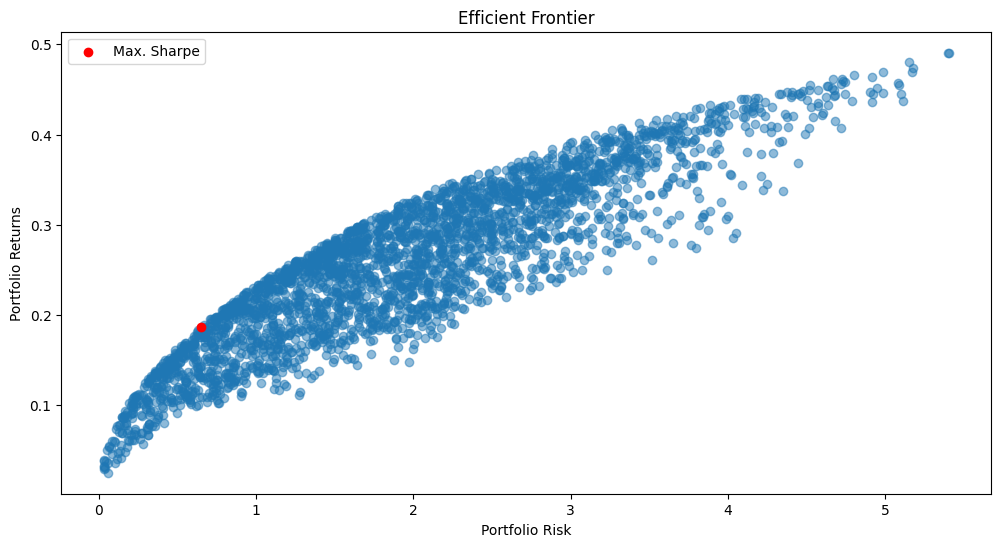

In [168]:
efficientFrontier(mean_returns,cov_matrix,opt_weights)

[*********************100%***********************]  3 of 3 completed


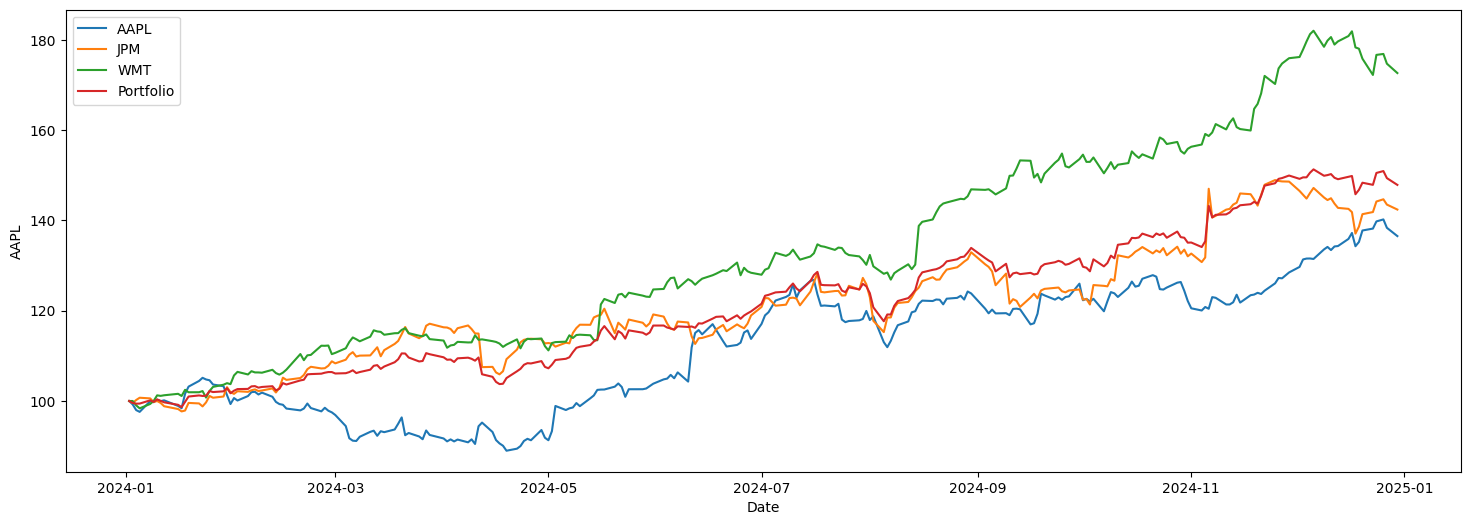

In [169]:
plotReturns(tickers,start_date,end_date,opt_weights)

[*********************100%***********************]  3 of 3 completed


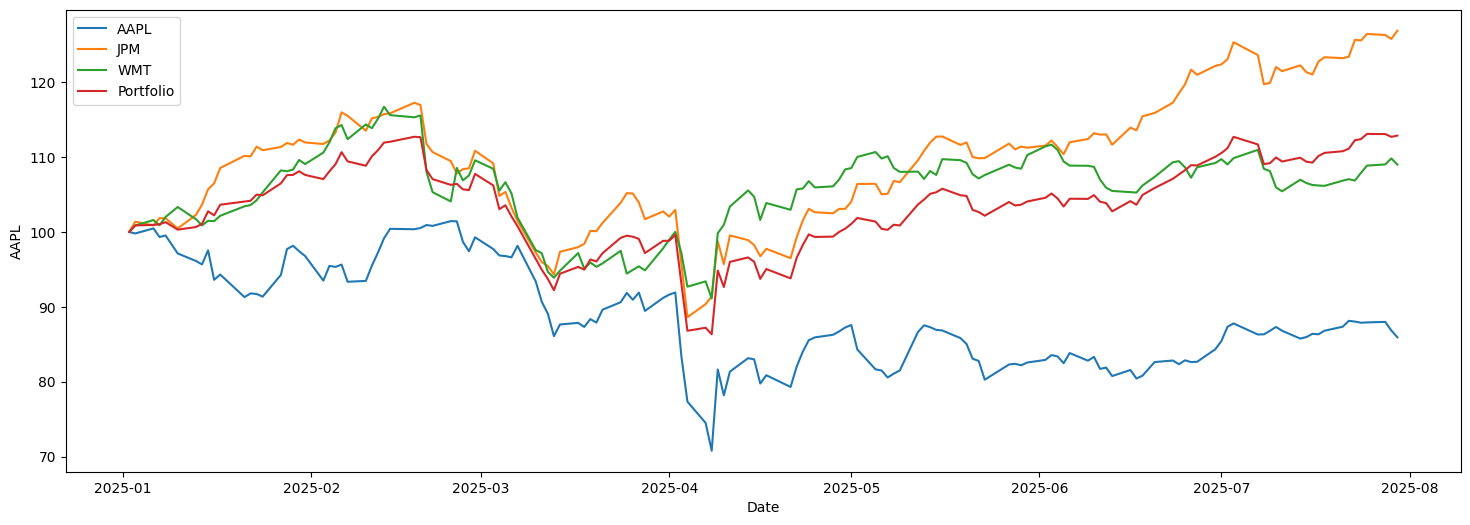

In [170]:
start_date = datetime(2025,1,1).date()
end_date = datetime(2025,7,31).date()
plotReturns(tickers,start_date,end_date,opt_weights)